In [184]:
import numpy as np 
from scipy.stats import norm
from scipy.linalg import cholesky

$$
\mathbb{P}\left(Y \in \cdot \mid Y \in \mathrm{S}_{\mu^{(t)}, \mathbf{i}}\right) \text { et } \mathbb{P}\left(Y \in \cdot \mid\left[\mu^{(t)}\right]^T Y=s\right)
$$
Pour le premier cas : on définit la strat, on tire un point au hasard dans la strat, et ensuite on échantillonne conditionnellement à ce point !
On le réécrit : 
$$
X=v^{\top} \xi \sim N\left(0, v^{\top} \Sigma v\right)=N(0,1)
$$
On a la distrbution conditionnelle : 

$$
(\xi \mid X=x) \sim N\left(\frac{\Sigma v}{v^{\top} \Sigma v} x, \Sigma-\frac{\Sigma v v^{\top} \Sigma}{v^{\top} \Sigma v}\right)=N\left(\Sigma v x, \Sigma-\Sigma v v^{\top} \Sigma\right)
$$
On utilise le tips ci-dessous pour pouvoir simuler (décomposition du terme en variance)

$$
\begin{aligned}
& \left(A-\Sigma v v^{\top} A\right)\left(A-\Sigma v v^{\top} A\right)^{\top} \\
& \quad=A A^{\top}-A A^{\top} v v^{\top} \Sigma-\Sigma v v^{\top} A A^{\top}+\Sigma v v^{\top} \Sigma v v^{\top} \Sigma \\
& \quad=\Sigma-\Sigma v v^{\top} \Sigma
\end{aligned}
$$

Suivant que l'on veuille sample avec ou non une condition sur la valeur de X, on le spécifie dans la fonction ci-dessous.

$$
\begin{aligned}
& \text { for } i=1, \ldots, K \\
& \quad \text { generate } U \sim \operatorname{Unif}[0,1] \\
& \quad V \leftarrow(i-1+U) / K \\
& \quad X \leftarrow \Phi^{-1}(V) \\
& \quad \text { generate } Z \sim N(0, I) \text { in } \Re^d \\
& \quad \xi \leftarrow \Sigma v X+\left(A-\Sigma v v^{\top} A\right) Z
\end{aligned}
$$

In [187]:
def stratified_sampling_linear_projection(mean, Sigma, v, K, x=None):
    """
    Generates K samples from N(0, Sigma) stratified along the direction determined by v.
    
    Args:
    - mean (array): The mean vector of the distribution.
    - Sigma (2D array): The covariance matrix of the distribution.
    - v (array): The vector along which stratification is done.
    - K (int): The number of stratified samples to generate.
    - x (optionnal) :  si on donne une valeur pour x alors c'est qu'on conditionne à une valeur particulière de x. Sinon on sample sur tout la strat Si. Taille K
    
    Returns:
    - samples (2D array): The generated stratified samples. (K, de N(0,sigma), stratifié sur la direction donnée par v)
    """
    d = len(mean)  # Dimension of the normal distribution
    # Normalize v so that v^T Sigma v = 1
    v = v / np.sqrt(v.T @ Sigma @ v)
    
    # Generate K stratified samples for the standard normal distribution along v
    U = np.random.uniform(0, 1, K)     # Uniformly distributed samples in (0,1)
    V = (np.arange(K) + U) / K         # Stratified samples in (0,1)
    
    X = norm.ppf(V)                    # Inverse CDF (quantile function) to get stratified samples for N(0, 1)
    
    # Compute the matrix A for the conditional distribution of xi given x
    A = cholesky(Sigma, lower=True)    # Cholesky factorization
    A_minus_v_Sigma_v_T_A = A - np.outer(Sigma @ v, v.T @ A)
    
    # Generate K samples from the conditional distribution of xi given X
    Z = np.random.randn(K, d)  # Z ~ N(0, I) in d dimensions 
    if x is not None:

        xi_samples = Sigma @ v * x[:, None] + (A_minus_v_Sigma_v_T_A @ Z.T).T  # Conditional samples 
        #xi_samples = Sigma @ v @ x + (A_minus_v_Sigma_v_T_A @ Z.T).T

    else:
        xi_samples = Sigma @ v * X[:, None] + (A_minus_v_Sigma_v_T_A @ Z.T).T 
        #xi_samples = Sigma @ v @ X + (A_minus_v_Sigma_v_T_A @ Z.T).T 
        
    
    return xi_samples + mean            # Add the mean to each sample

In [436]:
def tirer_K_nb(borne_inf, borne_sup, K):
    #vérifier comment tirer les nonbres uniformes sur -inf, a et sur a, +inf. Plusieurs manieres de faire je suis pas sur 
    if borne_inf == -np.inf:
        # Pour l'intervalle (-∞, b)

        u = np.random.uniform(0, 1, K)
        x_neg_inf = borne_sup - np.log(1 / u)
        return x_neg_inf

    elif borne_sup == np.inf:
        u = np.random.uniform(0, 1, K)
        x_pos_inf = borne_inf + np.log(1 / (1 - u))
        return x_pos_inf

    else:
        out = np.random.uniform(borne_inf , borne_sup, K)
        return out 

Tirage si dessous suivant une valeur de $\mathbb{P}\left(Y \in \cdot \mid\left[\mu_k^{(t)}\right]^T Y=s\right)$

Ici $s \in\left\{G_k^{-1}(1 / I), \cdots, G_k^{-1}((I-1) / I)\right\}$

In [190]:
def quantiles_normaux(I):
    """Args : I 
    return : les quantiles normaux, affiches ci-dessus;"""
   
    quantiles = [norm.ppf(k / I) for k in range(1, I)]
    
    return quantiles

In [192]:
# Example usage:
mean = np.array([1, 2, 3])               # Mean vector - on est en 3 dimensions 
Sigma = np.array([[1, 0.5, 0.1],       # Covariance matrix
                  [0.5, 2, 0.3],
                  [0.1, 0.3, 1]])
v = np.array([1, 1, 1])                # Vector for stratification which is centered 
K = 2                           # Number of samples to generate - 10 strates. Donc pour chaque strat les 3 coordonnées. 

# Generate stratified samples
samples = stratified_sampling_linear_projection(mean, Sigma, v, K, np.array([0.27,0.28]))
#samples  # Display first 5 samples for brevity
samples

array([[1.25108677, 1.40287989, 3.99627944],
       [1.24771324, 0.65153267, 4.77508339]])

Calcul de 
$$
\mathbb{P}\left(Y \in \cdot \mid Y \in \mathrm{S}_{\mu^{(t)}, \mathbf{i}}\right)
$$

on donne juste le i, numéro de la strat sur laquelle on veut tirer 

In [209]:
def tirer_y_strat_nu(mu, i, mean, Sigma, K, S):
    """

    Args : 
        - mu : l'orientation de la strat 
        - i : indice appartenant à 0....I-1 !! et pas 1,....I ATTENTION 
        - mean : moyenne de la v.a. Y 
        - sigma : variance de la v.a. Y 
        - S : nos strats 
    
    Outputs : tire K variables suivant l'indice i pour la strat donnée """

    return  stratified_sampling_linear_projection(mean, Sigma, mu, K, tirer_K_nb(S[i][0],S[i][1], K))

# Calcul de Si, la strat Si

$$
\mathrm{S}_{\mathbf{i}} \stackrel{\text { def }}{=} \prod_{k=1}^m\left(G_k^{-1}\left(\frac{i_k-1}{I}\right), G_k^{-1}\left(\frac{i_k}{I}\right)\right]
$$
On calcul Si, et on va tirer dedans. 

In [210]:
def strats_Si(I):
    # Calcul de Si pour chaque ik de 1 à I
    results = [(norm.ppf((ik - 1) / I), norm.ppf(ik / I)) for ik in range(1, I + 1)]
    return results

def p_i_mu(I):
    return 1/I

I = 100
strats = strats_Si(I)

# Tirer un point suivant une strat 

$$
\mathbb{P}\left(Y \in \cdot \mid Y \in \mathrm{S}_{\mu^{(t)}, \mathbf{i}}\right)
$$

In [214]:
i = 10

tirer_y_strat_nu(v, i, mean, Sigma, K, strats) # le nombre en dur est le numero de la strat ici de 0 à 99 car j'ai fais avec 100 levels dans l'exemple 

array([[0.00616716, 0.01540158, 2.95186818],
       [0.33255626, 0.07028231, 2.62180763]])

# Choix du vecteur d'allocation 

$$
\sigma_{\mathbf{i}}^2(\mu) \stackrel{\text { def }}{=} \mathrm{E}\left[\phi^2(Y) \mid \mu^T Y \in \mathrm{S}_{\mathbf{i}}\right]-\left(\mathrm{E}\left[\phi(Y) \mid \mu^T Y \in \mathrm{S}_{\mathbf{i}}\right]\right)^2
$$

Puis cela permet de calculer : 

$$
q_{\mathbf{i}}^{\star}(\mu) \stackrel{\text { def }}{=} \frac{p_{\mathbf{i}}(\mu) \sigma_{\mathbf{i}}(\mu)}{\sum_{\mathbf{j} \in \mathcal{I}} p_{\mathbf{j}}(\mu) \sigma_{\mathbf{j}}(\mu)} .
$$

In [203]:
# fonctions payoff arbitraires 

def phi(x):
    return x 

calcul du sigma i tel que défini ci-dessus. 

In [204]:
def sigma_i(v, i, mu, Sigma, K, results):
    #calcul simplement le sigma_i que l'on utilise. Sachant que le pi vaut 1/I 
    return np.sqrt(np.mean(phi(tirer_y_strat_nu(v,i,mu,Sigma,K,results))**2)- np.mean(phi(tirer_y_strat_nu(v,i,mu,Sigma,K,results)))**2)

In [205]:
sigma_i(v, 0, i, Sigma, 2000, strats)

TypeError: object of type 'int' has no len()

calcul du vecteur d'allocation optimale à l'instant initial. 

In [15]:
def calculate_q_star(mu, I, v, Sigma, K, results):
    # Initialisation du vecteur des sigmas
    sigma_values = np.zeros(I)
    
    # Calcul de chaque sigma_i pour un mu donné
    for i in range(I):
        sigma_values[i] = sigma_i(v, i, mu, Sigma, K, results)
    
    # Puisque p_i(mu) = 1/I pour tous i, on peut simplifier la somme
    sigma_p_sum = np.sum(sigma_values) / I  # C'est la somme de tous les sigma_i / I
    
    # Calcul de q_i*(mu) pour chaque i
    q_star = (sigma_values / sigma_p_sum) / I
    
    return q_star


In [16]:
qi = calculate_q_star(mu, 100, v, Sigma, 2000, results) #les allocations optimales qi 

Calcul des quantites Mi à allouer. 

In [17]:
def calculate_M(q, M):
    # Calculer la somme cumulative des qj
    cumulative_sums = [0] * len(q)
    cumulative_sums[0] = q[0]
    for i in range(1, len(q)):
        cumulative_sums[i] = cumulative_sums[i - 1] + q[i]

    # Calculer Mi pour chaque i
    Mi = []
    for i in range(len(q)):
        if i == 0:
            sum_j_less_i = 0  # Pas de j < i pour i = 0
        else:
            sum_j_less_i = cumulative_sums[i - 1]

        sum_j_less_equal_i = cumulative_sums[i]
        Mi.append(M * (sum_j_less_equal_i - sum_j_less_i))

    return Mi


In [386]:
M_i = calculate_M(qi,1000) #donne le nb de simu par strat. 

In [218]:
def initialisation(M, mean, I, mu, Sigma, K=2000):
    """Args : 
        - M : nb de simu total pour le sample 
        - mean, Sigma : moyenne et variance de Y
        - mu : direction de stratifaction 
        - K : nb de simu juste pour calculer les grandeurs intermediares tq sigma etc... """
    #renvoie ce qu'il faut pour étape 2 : à savoir les Mi, les pi, et la direction mu de stratifaction 
    results = strats_Si(I) #les strats 
    qi = calculate_q_star(mean, I, v, Sigma, K, results)
    
    return calculate_M(qi, M), np.array(I*[1/I]), mu

In [22]:
def create_positive_semi_definite_matrix(dim):
    # Générer une matrice aléatoire
    A = np.random.randn(dim, dim)
    
    # Utiliser le produit de A et sa transposée pour obtenir une matrice semi-définie positive
    B = np.dot(A, A.T)
    
    # Normaliser les diagonales pour que la diagonale soit 1
    D = np.sqrt(np.diag(B))
    B = B / D
    B = B / D[:, np.newaxis]
    
    return B

# Créer une matrice de corrélation semi-définie positive de dimension 5x5
dim = 5
correlation_matrix = create_positive_semi_definite_matrix(dim)


# ALGO

In [426]:
def compute_m(q, M):

    I = len(q)
    m = np.zeros(I)
    cumulative_sum = np.cumsum(q)

    m[0] = int(M*cumulative_sum[0])

    for i in range(1, I):

        m[i] = int(M*cumulative_sum[i]) - int(M*cumulative_sum[i-1]) 
    
    return np.array(m, dtype=int)

In [538]:
M = 10000
I = 100
d = 400
phi = lambda x : np.sum(x)
phi2 = lambda x: phi(x)**2

mean = np.zeros(d)
cov = create_positive_semi_definite_matrix(d)
strats = strats_Si(I)


mu0 = np.ones(d)/np.sqrt(d)
p0 = np.ones(I)/I

sigma0 = np.zeros(I)
K = 1000
for i in range(I):

    samples = tirer_y_strat_nu(mu0, i, mean, cov, K, strats)
    sigma0[i] = np.sqrt(np.mean(np.apply_along_axis(phi2, 1, samples))
                        - np.mean(np.apply_along_axis(phi, 1, samples))**2)

q0 = (p0 * sigma0)/np.sum(p0 * sigma0)
m0 = compute_m(q0, M)

In [468]:
def get_nu_and_grad_nu_estimates(mu, 
                                 p, 
                                 I, 
                                 d, 
                                 phi, 
                                 mean, 
                                 cov, 
                                 strats,
                                 m):

    phi2 = lambda x: phi(x)**2

    nu_f_phi = np.zeros((I))
    nu_f_phi2 = np.zeros((I))

    grad_nu_f = np.zeros((I, d))
    grad_nu_f_phi = np.zeros((I, d))
    grad_nu_f_phi2 = np.zeros((I, d))

    for i in range(I):

        samples = tirer_y_strat_nu(mu, i, mean, cov, m[i], strats)

        nu_f_phi[i] = p[i]*np.mean(np.apply_along_axis(phi, 1, samples))
        nu_f_phi2[i] = p[i]*np.mean(np.apply_along_axis(phi2, 1, samples))

        grad_nu_f[i] = - np.mean(samples, axis=0)/np.abs(mu)
        grad_nu_f_phi[i] = - np.mean(samples*np.apply_along_axis(phi, 1, samples)[:, np.newaxis]/np.abs(mu), axis=0)
        grad_nu_f_phi2[i] = - np.mean(samples*np.apply_along_axis(phi2, 1, samples)[:, np.newaxis]/np.abs(mu), axis=0)
    

    return nu_f_phi, nu_f_phi2, grad_nu_f, grad_nu_f_phi, grad_nu_f_phi2

In [469]:
nu_f_phi, nu_f_phi2, grad_nu_f, grad_nu_f_phi, grad_nu_f_phi2 = get_nu_and_grad_nu_estimates(mu0, p0, I, d, phi, mean, cov, strats, m0)

In [458]:
def get_p_sigma(nu_f_phi, nu_f_phi2):

    I = len(nu_f_phi)
    p = np.ones(I)/I
    sigma = np.sqrt(nu_f_phi2/p
                      - ((nu_f_phi)/p)**2)
    
    return p, sigma

In [459]:
p1, sigma1 = get_p_sigma(nu_f_phi, nu_f_phi2)

In [462]:
def get_grad_V(nu_f_phi, 
               nu_f_phi2, 
               grad_nu_f, 
               grad_nu_f_phi, 
               grad_nu_f_phi2, 
               p,
               sigma):
    
    I = len(nu_f_phi)
    grad_V = 0

    for i in range(I):

        if p[i]*sigma[i] != 0:

            term_to_add = (grad_nu_f[i] * nu_f_phi2[i]
                            + p[i] * grad_nu_f_phi2[i]
                            - 2 * nu_f_phi[i] * grad_nu_f_phi[i]) / (2 * p[i] * sigma[i])
            
            grad_V += term_to_add

    return grad_V

In [463]:
grad_V = get_grad_V(nu_f_phi, 
                   nu_f_phi2, 
                   grad_nu_f, 
                   grad_nu_f_phi, 
                   grad_nu_f_phi2, 
                   p1,
                   sigma1)

In [464]:
grad_V

array([-26.62756404, -18.73592379, -27.14201804])

In [465]:
def update_mu(mu,
              gamma, 
              grad_V):

    mu_hat = mu - gamma * grad_V

    # Perform singular value decomposition
    U, _, _ = np.linalg.svd(mu_hat[:, np.newaxis])

    # Define mu_(t+1) as the orthogonal matrix found by keeping the m left singular vectors
    mu_t_plus_1 = U[:, :1].T[0]

    return mu_t_plus_1

In [466]:
mu1 = update_mu(mu0, 0.1, grad_V)

In [467]:
mu1

array([0.61967251, 0.46874437, 0.62951147])

In [533]:
class Algorithm():

    def __init__(self,
                 M,
                 I,
                 d,
                 phi,
                 mean,
                 K: int=1000):

        self.M = M
        self.I = I
        self.d = d
        self.phi = phi
        self.phi2 = lambda x: phi(x)**2

        self.mean = mean
        self.cov = cov
        self.strats = strats_Si(I)


        self.mu = np.ones(d)/np.sqrt(d)
        self.p = np.ones(I)/I

        sigma0 = np.zeros(I)
        for i in range(I):
            samples = tirer_y_strat_nu(mu0, i, mean, cov, K, strats)
            sigma0[i] = np.sqrt(np.mean(np.apply_along_axis(phi2, 1, samples))
                                - np.mean(np.apply_along_axis(phi, 1, samples))**2)
        self.sigma = sigma0
        
        self.q = (p0 * sigma0)/np.sum(p0 * sigma0)
        self.m = compute_m(q0, M)

    
    def compute_nu_and_grad_nu_estimates(self):

        nu_f_phi = np.zeros((self.I))
        nu_f_phi2 = np.zeros((self.I))

        grad_nu_f = np.zeros((self.I, self.d))
        grad_nu_f_phi = np.zeros((self.I, self.d))
        grad_nu_f_phi2 = np.zeros((self.I, self.d))

        for i in range(self.I):

            samples = tirer_y_strat_nu(self.mu, i, self.mean, self.cov, self.m[i], self.strats)

            nu_f_phi[i] = self.p[i]*np.mean(np.apply_along_axis(self.phi, 1, samples))
            nu_f_phi2[i] = self.p[i]*np.mean(np.apply_along_axis(self.phi2, 1, samples))

            grad_nu_f[i] = - np.mean(samples, axis=0)/np.abs(self.mu)
            grad_nu_f_phi[i] = - np.mean(samples*np.apply_along_axis(self.phi, 1, samples)[:, np.newaxis]/np.abs(self.mu), axis=0)
            grad_nu_f_phi2[i] = - np.mean(samples*np.apply_along_axis(self.phi2, 1, samples)[:, np.newaxis]/np.abs(self.mu), axis=0)
        
        return nu_f_phi, nu_f_phi2, grad_nu_f, grad_nu_f_phi, grad_nu_f_phi2


    def compute_grad_V_estimate(self, nu_f_phi, nu_f_phi2, grad_nu_f, 
                                grad_nu_f_phi, grad_nu_f_phi2):
        
        grad_V = 0

        for i in range(self.I):

            if self.p[i]*self.sigma[i] != 0:

                term_to_add = (grad_nu_f[i] * nu_f_phi2[i]
                                + self.p[i] * grad_nu_f_phi2[i]
                                - 2 * nu_f_phi[i] * grad_nu_f_phi[i]) / (2 * self.p[i] * self.sigma[i])
                
                grad_V += term_to_add

        return grad_V
    

    def update_mu_sigma_q_p(self, gamma):

        (nu_f_phi, nu_f_phi2, grad_nu_f, 
         grad_nu_f_phi, grad_nu_f_phi2) = self.compute_nu_and_grad_nu_estimates()
        
        grad_V = self.compute_grad_V_estimate(nu_f_phi, nu_f_phi2, grad_nu_f, 
                                               grad_nu_f_phi, grad_nu_f_phi2)


        # Update mu
        mu_tilde = self.mu - gamma * grad_V
        U, _, _ = np.linalg.svd(mu_tilde[:, np.newaxis])
        self.mu = U[:, :1].T[0]

        # Update sigma 
        self.sigma = np.sqrt(nu_f_phi2/self.p
                        - ((nu_f_phi)/self.p)**2)
        
        # Update q
        self.q = (self.p * self.sigma)/np.sum(self.p * self.sigma)
        
        # Update p
        self.p = np.ones(self.I)/self.I

        # Update m
        self.m = compute_m(self.q, self.M)

    
    def compute_V(self):

        return np.sum(self.p * self.sigma)

    def compute_algorithm_iteration(self,
                                    N: int=1000,
                                    callback: bool=True):
        
        if callback:

            V = np.zeros(N+1)
            V[0] = self.compute_V()
            mus = [self.mu]

        for n in range(1, N+1):
            
            gamma = 1 / n 

            self.update_mu_sigma_q_p(gamma)
            
            if callback:
                
                V[n] = self.compute_V()
                mus.append(self.mu)
        
        return V, mus

In [539]:
algo = Algorithm(M,
                 I,
                 d,
                 phi,
                 mean)

In [542]:
V, mus = algo.compute_algorithm_iteration(N = 50)

In [541]:
V

array([ 0.65046018,  0.66877845, 17.64313195, 19.5813002 , 19.54948059,
       19.42751408, 19.38192633, 19.33721445, 19.58660231, 19.32458687,
       19.4788846 ])

In [529]:
algo.m

array([469,  97,  98,  94,  91,  92,  84,  87,  92,  96,  92, 103, 102,
        95,  96,  77, 103,  89, 103,  89,  87,  94,  82,  93, 103,  92,
        96,  96,  87,  99,  89,  95,  88,  95,  92, 106,  94,  93,  92,
       104,  90,  85,  89,  87,  82,  98,  96,  85,  98, 100,  89,  93,
        93,  99, 105,  99,  85, 102,  93,  97,  93,  92,  92,  93,  87,
        91, 103,  90,  94, 102,  90,  97,  88,  88,  98,  94, 102,  99,
        85,  93,  92, 103,  86,  84,  94,  77,  90,  94,  94,  97, 102,
        94,  90,  93,  92,  92, 110, 106, 101, 347])

In [513]:
import matplotlib.pyplot as plt

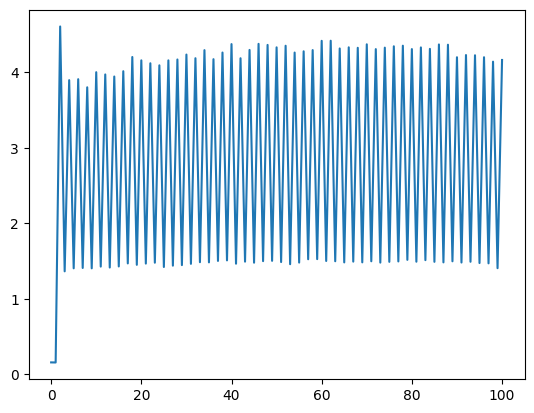

In [514]:
plt.plot(V)